In [3]:
import cv2
print(cv2.__version__)

4.10.0


In [ ]:
!pip -q install opencv-contrib-python==4.10.0.84 pdf2image==1.17.0 matplotlib==3.9.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.7/68.7 MB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 96.2 MB/s eta 0:00:00


In [4]:
from google.colab import files
uploaded = files.upload()
img_path = next(iter(uploaded.keys()))

cb_img = cv2.imread(img_path)  # directly load PNG/JPG
print(cb_img.shape)

Saving checkerboard.jpg to checkerboard.jpg
(2481, 3508, 3)


Detected inner-corner size: (9, 6)


Text(0.5, 1.0, 'Detected (9, 6) on base')

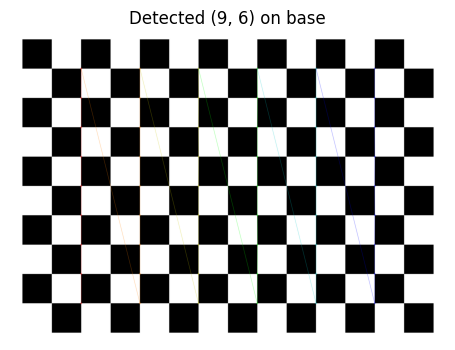

In [9]:
import cv2, numpy as np, itertools as it
import matplotlib.pyplot as plt

# Use your already loaded cb_img
gray0 = cv2.cvtColor(cb_img, cv2.COLOR_BGR2GRAY)

# Try a small grid of plausible inner-corner sizes
# (common sheets: 9x6, 10x7, 11x8, 12x8, 13x8, etc.)
candidates = [
    (9,6), (10,7), (11,8), (12,8), (13,8), (14,9),
    (8,5), (7,5), (6,5)  # add a few smaller fallbacks
]

pattern_size = None
best_pts = None

for ps in candidates:
    ok, pts = cv2.findChessboardCornersSB(gray0, ps, flags=cv2.CALIB_CB_EXHAUSTIVE)
    if ok:
        pattern_size = ps
        best_pts = pts
        break

if pattern_size is None:
    # Fallback: try legacy API with normalization
    for ps in candidates:
        ok, pts = cv2.findChessboardCorners(
            gray0, ps, flags=cv2.CALIB_CB_ADAPTIVE_THRESH + cv2.CALIB_CB_NORMALIZE_IMAGE
        )
        if ok:
            pattern_size = ps
            best_pts = pts
            break

assert pattern_size is not None, "Could not detect any plausible checkerboard on the base image. Check that cb_img is your checkerboard."

print("Detected inner-corner size:", pattern_size)

vis = cb_img.copy()
cv2.drawChessboardCorners(vis, pattern_size, best_pts, True)
plt.figure(figsize=(6,4))
plt.imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB)); plt.axis("off"); plt.title(f"Detected {pattern_size} on base")

In [10]:
import numpy as np, cv2

# ==== SPEED/ROBUSTNESS SETTINGS ====
TARGET_SUCCESSES = 10
MAX_ATTEMPTS     = 60
TARGET_WIDTH     = 900
PADDING_FRAC     = 0.12   # keep margins so the whole board stays visible
MAX_SKEW_FRAC    = 0.15   # limit perspective skew (0.10~0.18 works well)
# ===================================

# Downscale once
h0, w0 = cb_img.shape[:2]
scale = TARGET_WIDTH / w0 if w0 > TARGET_WIDTH else 1.0
cb_small = cv2.resize(cb_img, None, fx=scale, fy=scale, interpolation=cv2.INTER_AREA)
g0 = cv2.cvtColor(cb_small, cv2.COLOR_BGR2GRAY)
H0, W0 = g0.shape[:2]

# Build padded destination rectangle
pad = int(PADDING_FRAC * min(H0, W0))
dest_rect = np.float32([[pad, pad],
                        [W0 - pad, pad],
                        [W0 - pad, H0 - pad],
                        [pad, H0 - pad]])

# Source is the full image
src_rect = np.float32([[0,0],[W0,0],[W0,H0],[0,H0]])

# OBJ points (Z=0 plane)
# NOTE: use the detected size above
cols, rows = pattern_size
square_size = 0.02
objp = np.zeros((cols*rows, 3), np.float32)
objp[:,:2] = np.mgrid[0:cols, 0:rows].T.reshape(-1,2) * square_size

rng = np.random.default_rng(123)

def synthesize_view_gray(img_gray):
    H, W = img_gray.shape[:2]
    # Start from padded rectangle then add LIMITED perspective skew
    J = dest_rect.copy()
    skew_x = int(MAX_SKEW_FRAC * (W - 2*pad))
    skew_y = int(MAX_SKEW_FRAC * (H - 2*pad))

    # skew corners a bit (keeps convexity and full board in view)
    # top-left
    J[0,0] += rng.integers(-skew_x, skew_x+1)
    J[0,1] += rng.integers(-skew_y, skew_y+1)
    # top-right
    J[1,0] += rng.integers(-skew_x, skew_x+1)
    J[1,1] += rng.integers(-skew_y, skew_y+1)
    # bottom-right
    J[2,0] += rng.integers(-skew_x, skew_x+1)
    J[2,1] += rng.integers(-skew_y, skew_y+1)
    # bottom-left
    J[3,0] += rng.integers(-skew_x, skew_x+1)
    J[3,1] += rng.integers(-skew_y, skew_y+1)

    Hmat = cv2.getPerspectiveTransform(src_rect, J)
    warped = cv2.warpPerspective(img_gray, Hmat, (W, H),
                                 flags=cv2.INTER_LINEAR,
                                 borderMode=cv2.BORDER_CONSTANT, borderValue=255)

    # simple contrast bump helps SB
    warped = cv2.equalizeHist(warped)
    return warped

def detect_corners(gray, pattern_size):
    # Prefer SB; it’s fast/robust
    if hasattr(cv2, "findChessboardCornersSB"):
        flags = cv2.CALIB_CB_ACCURACY  # good default; EXHAUSTIVE is slower
        ok, pts = cv2.findChessboardCornersSB(gray, pattern_size, flags=flags)
        if ok and pts.ndim == 2:
            pts = pts.reshape(-1,1,2).astype(np.float32)
        return ok, pts
    # Fallback legacy
    ok, pts = cv2.findChessboardCorners(
        gray, pattern_size,
        flags=cv2.CALIB_CB_ADAPTIVE_THRESH + cv2.CALIB_CB_NORMALIZE_IMAGE
    )
    if ok:
        pts = cv2.cornerSubPix(gray, pts, (11,11), (-1,-1),
                               (cv2.TERM_CRITERIA_EPS+cv2.TERM_CRITERIA_MAX_ITER, 60, 1e-4))
    return ok, pts

objpoints, imgpoints, view_kept = [], [], []
attempts = 0

while len(view_kept) < TARGET_SUCCESSES and attempts < MAX_ATTEMPTS:
    attempts += 1
    wgray = synthesize_view_gray(g0)
    ok, pts = detect_corners(wgray, pattern_size)
    if not ok:
        continue
    objpoints.append(objp.copy())
    imgpoints.append(pts.astype(np.float32))
    view_kept.append(cv2.cvtColor(wgray, cv2.COLOR_GRAY2BGR))

print(f"Successes: {len(view_kept)} / attempts: {attempts}")
assert len(view_kept) > 0, "Still no detections. Try increasing MAX_ATTEMPTS or lowering MAX_SKEW_FRAC to 0.10."


Successes: 9 / attempts: 60


OpenCV RMS reprojection error: 6.366541124276513
OpenCV K =
 [[5.98458408e+03 0.00000000e+00 3.20363388e+02]
 [0.00000000e+00 1.43437750e+04 3.35831376e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
OpenCV dist (k1,k2,p1,p2,k3,...)=
 [ 1.42349808e+01 -3.52703444e+03 -7.56240645e-02 -1.58115409e-01
 -2.54049880e+01]


(np.float64(-0.5), np.float64(899.5), np.float64(636.5), np.float64(-0.5))

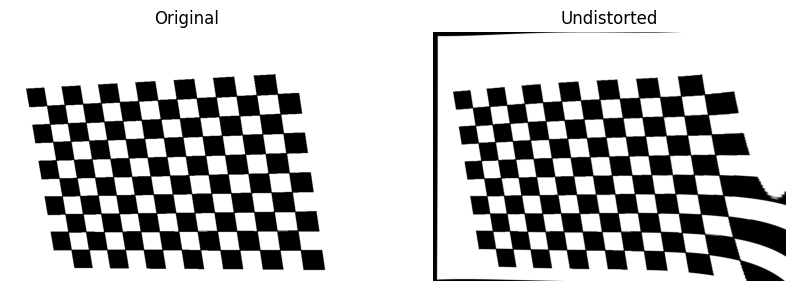

In [11]:
# === Step 4: OpenCV calibration ===
image_size = (view_kept[0].shape[1], view_kept[0].shape[0])  # (width, height)

flags = 0  # start simple (no fixed params)
ret_rms, K_cv, dist_cv, rvecs_cv, tvecs_cv = cv2.calibrateCamera(
    objectPoints=objpoints,
    imagePoints=imgpoints,
    imageSize=image_size,
    cameraMatrix=None,
    distCoeffs=None,
    flags=flags
)

print("OpenCV RMS reprojection error:", ret_rms)
print("OpenCV K =\n", K_cv)
print("OpenCV dist (k1,k2,p1,p2,k3,...)=\n", dist_cv.ravel()[:5])

# Quick visual check
sample = view_kept[0]
und = cv2.undistort(sample, K_cv, dist_cv)
import matplotlib.pyplot as plt
plt.figure(figsize=(10,4))
plt.subplot(1,2,1); plt.imshow(cv2.cvtColor(sample, cv2.COLOR_BGR2RGB)); plt.title('Original'); plt.axis('off')
plt.subplot(1,2,2); plt.imshow(cv2.cvtColor(und,   cv2.COLOR_BGR2RGB)); plt.title('Undistorted'); plt.axis('off')

In [13]:
# === Step 5 (robust Zhang linear) ===
import numpy as np
import numpy.linalg as npl
import math

def normalize_points_2d(pts):
    """
    pts: (N,2)
    Returns T (3x3) and normalized ptsn (N,2) with mean=0, mean dist = sqrt(2)
    """
    c = pts.mean(axis=0)
    d = np.sqrt(((pts - c)**2).sum(axis=1)).mean()
    s = np.sqrt(2) / (d + 1e-12)
    T = np.array([[s, 0, -s*c[0]],
                  [0, s, -s*c[1]],
                  [0, 0,       1.0]])
    pts_h = np.column_stack([pts, np.ones(len(pts))])
    ptsn_h = (T @ pts_h.T).T
    return T, ptsn_h[:, :2]

def homography_DLT_normalized(XY, uv):
    """
    XY: (N,2) world points (Z=0), uv: (N,2) image points
    Normalized DLT -> denormalize -> H (3x3) with H[2,2]=1
    """
    TX, XYn = normalize_points_2d(XY)
    TU, uvn = normalize_points_2d(uv)

    N = XY.shape[0]
    A = []
    for i in range(N):
        x,y = XYn[i]
        u,v = uvn[i]
        A.append([ -x, -y, -1,  0,  0,  0,  u*x, u*y, u ])
        A.append([  0,  0,  0, -x, -y, -1,  v*x, v*y, v ])
    A = np.asarray(A, np.float64)

    _, _, VT = npl.svd(A)
    Hn = VT[-1].reshape(3,3)
    # denormalize: H = TU^{-1} * Hn * TX
    H = npl.inv(TU) @ Hn @ TX
    return H / H[2,2]

def v_ij(H, i, j):
    h = H.T  # columns are h0,h1,h2
    return np.array([
        h[i,0]*h[j,0],
        h[i,0]*h[j,1] + h[i,1]*h[j,0],
        h[i,1]*h[j,1],
        h[i,2]*h[j,0] + h[i,0]*h[j,2],
        h[i,2]*h[j,1] + h[i,1]*h[j,2],
        h[i,2]*h[j,2]
    ], dtype=np.float64)

def intrinsic_from_homographies_SPD(Hs):
    # Build V* b = 0 to estimate b for B (symmetric)
    V = []
    for H in Hs:
        V.append(v_ij(H, 0, 1))
        V.append(v_ij(H, 0, 0) - v_ij(H, 1, 1))
    V = np.asarray(V, np.float64)
    _, _, VT = npl.svd(V)
    b = VT[-1]  # [B11, B12, B22, B13, B23, B33]

    B11, B12, B22, B13, B23, B33 = b
    B = np.array([[B11, B12, B13],
                  [B12, B22, B23],
                  [B13, B23, B33]], dtype=np.float64)

    # Project B to nearest SPD to avoid negative sqrt:
    # Symmetrize, then eigen floor
    B = 0.5*(B + B.T)
    w, Q = npl.eigh(B)
    w_clamped = np.clip(w, 1e-12, None)  # ensure positive
    B_spd = (Q @ np.diag(w_clamped) @ Q.T)

    # K from inv(cholesky(B)) up to scale; enforce K[2,2]=1 and positive fx,fy
    C = npl.cholesky(B_spd)              # B = C C^T
    Kinv = C.T                           # one valid factor since B = (K^-T)(K^-1)
    K = npl.inv(Kinv)
    K = K / K[2,2]
    if K[0,0] < 0: K[:,0] *= -1
    if K[1,1] < 0: K[:,1] *= -1
    return K

def extrinsics_from_H(K, H):
    Kinv = npl.inv(K)
    h1, h2, h3 = H[:,0], H[:,1], H[:,2]
    lam = 1.0 / npl.norm(Kinv @ h1)
    r1 = lam * (Kinv @ h1)
    r2 = lam * (Kinv @ h2)
    r3 = np.cross(r1, r2)
    t  = lam * (Kinv @ h3)
    # Orthonormalize
    U,_,VT = npl.svd(np.column_stack([r1,r2,r3]))
    R = U @ VT
    return R, t

# Build homographies using only the inner-corner correspondences you already have
XY = objpoints[0][:,:2]  # same XY for all views (Z=0)
Hs = []
cond_ok = []
for pts2d in imgpoints:
    uv = pts2d.squeeze().astype(np.float64)
    H = homography_DLT_normalized(XY, uv)

    # discard badly conditioned H (helps stability)
    svals = npl.svd(H[:2,:2], compute_uv=False)
    if (svals[1] / (svals[0] + 1e-12)) < 1e-3:
        cond_ok.append(False)
        continue
    cond_ok.append(True)
    Hs.append(H)

assert len(Hs) >= 3, "Need >=3 good homographies. Generate a few more views or relax the conditioning."

K_zhang = intrinsic_from_homographies_SPD(Hs)
print("Zhang (robust linear) K =\n", K_zhang)

# Per-view extrinsics and linear reprojection error (no distortion)
def reproj_err(K, R, t, XY, uv):
    XY1 = np.column_stack([XY, np.zeros((XY.shape[0],1)), np.ones((XY.shape[0],1))])
    P = K @ np.column_stack([R, t.reshape(3,1)])
    proj = (P @ XY1.T).T
    proj = proj[:,:2] / proj[:,2:3]
    return np.sqrt(np.mean(((proj - uv)**2).sum(axis=1)))

errs = []
Rt_zhang = []
for pts2d in imgpoints:
    uv = pts2d.squeeze().astype(np.float64)
    H = homography_DLT_normalized(XY, uv)
    R, t = extrinsics_from_H(K_zhang, H)
    Rt_zhang.append((R,t))
    errs.append(reproj_err(K_zhang, R, t, XY, uv))

print("Zhang (linear, no distortion) mean reprojection error (px):", float(np.mean(errs)))

Zhang (robust linear) K =
 [[1.96017587e+01 5.90168593e+00 3.99123636e+03]
 [0.00000000e+00 1.84889638e+01 2.51342942e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
Zhang (linear, no distortion) mean reprojection error (px): 119.35116043012926


In [14]:
def summarize_K(K):
    fx, fy = K[0,0], K[1,1]
    cx, cy = K[0,2], K[1,2]
    skew   = K[0,1]
    return dict(fx=fx, fy=fy, cx=cx, cy=cy, skew=skew)

print("OpenCV K:", summarize_K(K_cv))
print("Zhang  K:", summarize_K(K_zhang))
print("OpenCV RMS:", float(ret_rms))
print("Zhang mean reproj err (px):", float(np.mean(errs)))

OpenCV K: {'fx': np.float64(5984.584084662137), 'fy': np.float64(14343.775017077713), 'cx': np.float64(320.3633880794019), 'cy': np.float64(335.8313762182867), 'skew': np.float64(0.0)}
Zhang  K: {'fx': np.float64(19.601758694187513), 'fy': np.float64(18.48896379706629), 'cx': np.float64(3991.2363595870506), 'cy': np.float64(2513.4294150891874), 'skew': np.float64(5.90168592701322)}
OpenCV RMS: 6.366541124276513
Zhang mean reproj err (px): 119.35116043012926


Text(0.5, 1.0, 'Zhang reprojection (green)')

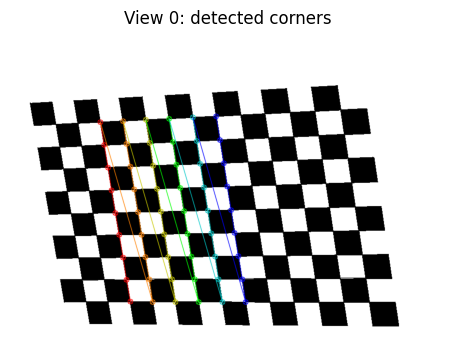

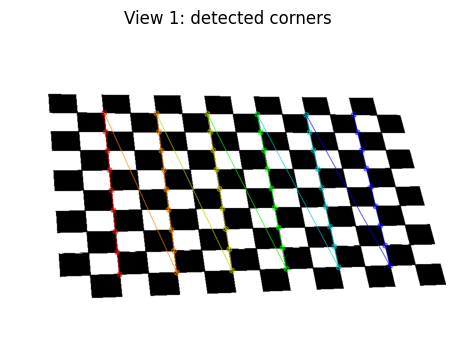

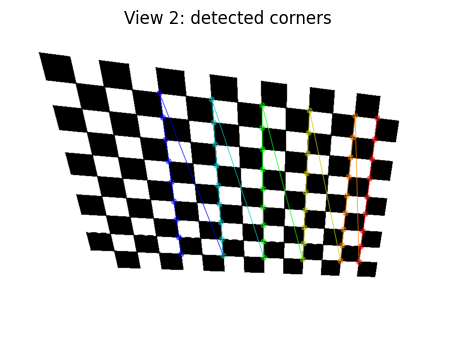

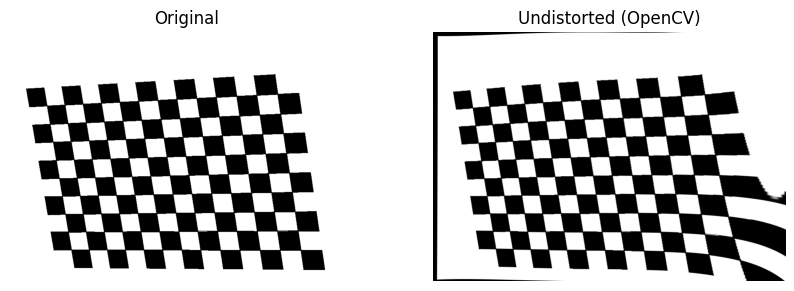

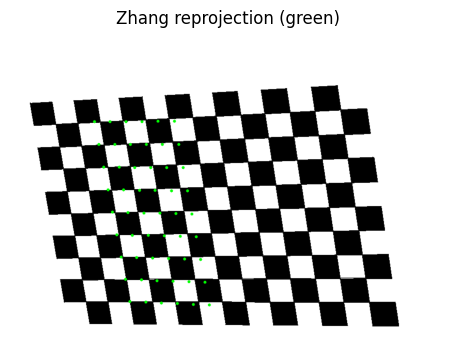

In [15]:
# Show a couple of views with detected corners
for i in range(min(3, len(view_kept))):
    im = view_kept[i].copy()
    cv2.drawChessboardCorners(im, pattern_size, imgpoints[i], True)
    plt.figure(figsize=(6,4))
    plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
    plt.axis('off'); plt.title(f'View {i}: detected corners')

# Undistort using OpenCV results
sample = view_kept[0]
und = cv2.undistort(sample, K_cv, dist_cv)
plt.figure(figsize=(10,4))
plt.subplot(1,2,1); plt.imshow(cv2.cvtColor(sample, cv2.COLOR_BGR2RGB)); plt.title('Original'); plt.axis('off')
plt.subplot(1,2,2); plt.imshow(cv2.cvtColor(und, cv2.COLOR_BGR2RGB)); plt.title('Undistorted (OpenCV)'); plt.axis('off')

# Reprojection overlay (Zhang) for the first view
R0, t0 = Rt_zhang[0]
XY1 = np.column_stack([XY, np.zeros((XY.shape[0],1)), np.ones((XY.shape[0],1))])
P0 = K_zhang @ np.column_stack([R0, t0.reshape(3,1)])
proj = (P0 @ XY1.T).T
proj = proj[:,:2] / proj[:,2:3]

im = view_kept[0].copy()
for (u,v) in proj.astype(int):
    cv2.circle(im, (u,v), 3, (0,255,0), -1)
plt.figure(figsize=(6,4))
plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
plt.axis('off'); plt.title('Zhang reprojection (green)')